In [1]:
from dggrid4py import DGGRIDv7
from dggrid4py import igeo7
import tempfile
import shapely
from shapely.ops import transform
import pyproj
import geopandas as gpd
from matplotlib import pyplot as plt
from find_neighbours import find_neighbours
import numpy as np
import tqdm
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

In [2]:
# using dggrid4py 0.4.0
tmp = tempfile.TemporaryDirectory()
dggrid = DGGRIDv7('/home/dick/micromamba/envs/xdggs/bin/dggrid', working_dir=tmp.name, silent=True)

## Using [z7_k_ring_neighbours](https://gitlab.ut.ee/geog/lgeo_datacube/-/issues/99) for validation

In [3]:
def z7_k_ring_neighbours(z7_str, dggrid_instance, cls_m, k_ring = 1):
    resolution = igeo7.get_z7string_resolution(z7_str)
    parent, local_pos, is_center = igeo7.get_z7string_local_pos(z7_str)

    if is_center:
        # print("could be straightforward return: replace 0 with 1-6")
        pass

    if k_ring <= 0:
        raise ValueError(f"K-ring with {k_ring} (self) or negative (error). Should be 1 or larger.")
    elif k_ring > 1:
        raise ValueError(f"K-ring with larger than 1 ({k_ring}) not yet implemented.")

    # gdf = dggrid_instance.grid_cell_polygons_from_cellids(df.index,
    the_one = dggrid_instance.grid_cell_centroids_from_cellids([z7_str],
                                                dggs_type='IGEO7',
                                                resolution=resolution,
                                                input_address_type='Z7_STRING',
                                                output_address_type='Z7_STRING').iloc[0]['geometry']

    if not (-180 <= the_one.x <= 180) and not (-90 <= the_one.y <= 90):
        raise ValueError(f"Not a valid WGS84 geom: {str(the_one.wkt)}")
        
    local_proj_str = f"+proj=laea +lat_0={the_one.y} +lon_0={the_one.x}"
    local_projection = pyproj.Transformer.from_crs('EPSG:4236', local_proj_str, always_xy=True).transform
    lamb_geom = transform(local_projection, the_one)

    # mistake lamb_point ---> neighbour_field_local = lamb_point.buffer(cls_m)
    neighbour_field_local = lamb_geom.buffer(cls_m)

    inverse = pyproj.Transformer.from_crs(local_proj_str, 'EPSG:4236', always_xy=True).transform
    neighbour_field = transform(inverse, neighbour_field_local)
    
    k_ring_group = dggrid_instance.grid_cell_centroids_for_extent('IGEO7', resolution, clip_geom=neighbour_field, output_address_type='Z7_STRING')
    k_ring_group.crs = 4326
    # we could technically already drop the geometry? But maybe need for the orientations

    # we should drop the centre, right?!
    k_ring_group = k_ring_group.drop(k_ring_group.loc[k_ring_group['name'] == z7_str].index[0])
    # ideally we order/index them according to Z7 local_pos
    
    k_ring_group['local_pos'] = k_ring_group['name'].apply(lambda cellid: cellid[-1:])
    return k_ring_group
    
def dggrid_get_res(dggrid_instance, dggrid_dggs="ISEA7H", max_res=16):

    isea7h_res = dggrid_instance.grid_stats_table(dggrid_dggs, max_res)
    isea7h_res = isea7h_res.rename(
        columns={
            "Resolution": f"{dggrid_dggs}_resolution",
            "Area (km^2)": "average_hexagon_area_km2",
            "CLS (km)": "cls_km",
        }
    )
    isea7h_res = isea7h_res.rename(
        columns={col: col.lower().replace(" ", "_") for col in isea7h_res.columns}
    ).set_index(f"{dggrid_dggs.lower()}_resolution")
    isea7h_res["average_hexagon_area_m2"] = np.float32(
        isea7h_res["average_hexagon_area_km2"] * 1000000
    )
    isea7h_res["cls_m"] = np.float32(isea7h_res["cls_km"] * 1000)
    return isea7h_res


## Generate cells id by using dggrid on a extent

In [10]:
res=14
box = shapely.geometry.box(2542500., 1561500. ,6013500., 5417500)
tartu_polygon = shapely.Polygon([[26.496084308689888, 58.433055188203284],
          [26.496084308689888, 58.304134878290405],
          [26.903951740330513, 58.304134878290405],
          [26.903951740330513, 58.433055188203284]])
tartu_polygon.bounds
box = gpd.GeoSeries([shapely.box(*tartu_polygon.bounds)], crs='wgs84').to_crs('wgs84')
box.total_bounds
cellids_gdf = dggrid.grid_cell_polygons_for_extent('IGEO7', res, clip_geom=box.geometry.values[0], output_address_type='Z7_STRING')
cellids_gdf.to_parquet(f'testing_gpd_res_{res}.parquet')
cellids_gdf = gpd.read_parquet(f'./testing_gpd_res_{res}.parquet')

## Prepare validation set by sampling 10,000 cells id from the dataframe

In [25]:
cls_m = dggrid_get_res(dggrid).iloc[res][-1]

In [26]:
# generate 10000 sample from the validation set
ridx = np.random.choice(len(cellids_gdf), 10000, replace=False)
validation_set = {}
for r in ridx:
    neighbours = z7_k_ring_neighbours(cellids_gdf.iloc[r]['name'], dggrid, cls_m)['name'].values
    validation_set[cellids_gdf.iloc[r]['name']] = neighbours

In [27]:
validattion_result = []
for k, v in tqdm.tqdm(validation_set.items()):
    n = find_neighbours(k)
    leftlen = len(v)
    # z7_kring sometime will return more than 6 neighbours
    # so we check if n is a subset of v
    r = set(n).issubset(set(v))
    validattion_result.append([k, leftlen, r])

100%|██████████████████████████████████| 10000/10000 [00:03<00:00, 2698.70it/s]


In [28]:
validattion_result = pd.DataFrame(validattion_result, columns=['cellid','z7_k_ring_len','issubset'])

In [29]:
validattion_result[validattion_result['z7_k_ring_len']!=6]#.to_csv('z7_k_ring_more_than_6_neighours.csv',index=False)

cellid  z7_k_ring_len  issubset
1     0001026100112214              4     False
2     0001026151411121              3     False
4     0001020242652164              4     False
5     0001026112404364              4     False
6     0001020265433410              4     False
...                ...            ...       ...
9995  0001026134005330              4     False
9996  0001020244413603              5     False
9997  0001020261035364              5     False
9998  0001026106013142              5     False
9999  0001026111513301              4     False

[8231 rows x 3 columns]

In [30]:
validattion_result[validattion_result['issubset']==False]

cellid  z7_k_ring_len  issubset
1     0001026100112214              4     False
2     0001026151411121              3     False
4     0001020242652164              4     False
5     0001026112404364              4     False
6     0001020265433410              4     False
...                ...            ...       ...
9995  0001026134005330              4     False
9996  0001020244413603              5     False
9997  0001020261035364              5     False
9998  0001026106013142              5     False
9999  0001026111513301              4     False

[7821 rows x 3 columns]

In [37]:
z7_n = z7_k_ring_neighbours('0001026134005330', dggrid, cls_m)

In [38]:
n = find_neighbours('0001026134005330')
n

array(['0001026134005331', '0001026134005332', '0001026134005333',
       '0001026134005334', '0001026134005335', '0001026134005336'],
      dtype='<U16')

In [39]:
z7_n_df = dggrid.grid_cell_polygons_from_cellids(z7_n['name'].values, 'IGEO7',res, input_address_type='Z7_STRING',output_address_type='Z7_STRING')

In [40]:
n_df = dggrid.grid_cell_polygons_from_cellids(n, 'IGEO7',res, input_address_type='Z7_STRING',output_address_type='Z7_STRING')

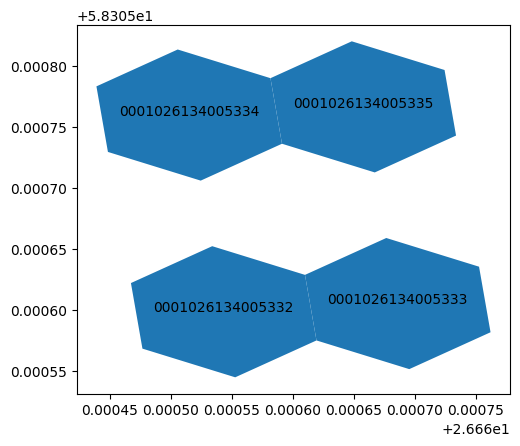

In [41]:
ax = z7_n_df.plot()
z7_n_df.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

array(['0001026134005331', '0001026134005332', '0001026134005333',
       '0001026134005334', '0001026134005335', '0001026134005336'],
      dtype='<U16')

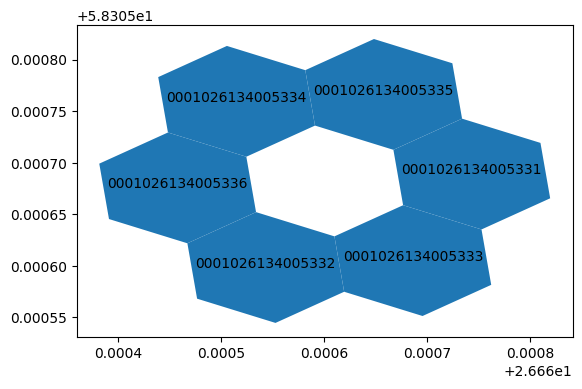

In [42]:
ax = n_df.plot()
n_df.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
n

In [17]:
dggrid.grid_cell_polygons_from_cellids(['00021121233'], 'IGEO7',9, input_address_type='Z7_STRING',output_address_type='Z7_STRING')

name                                           geometry
0  00063363622  POLYGON ((11.43686 50.66545, 11.42667 50.66498...

In [46]:
dggrid.address_transform(['00021121233'], 'IGEO7', 9, input_address_type='Z7_STRING', output_address_type='Q2DI')

Z7_STRING          Q2DI
0  00021121233  3 1144 15716

In [47]:
dggrid.address_transform(['00063363622'], 'IGEO7', 9, input_address_type='Z7_STRING', output_address_type='Q2DI')

Z7_STRING          Q2DI
0  00063363622  3 1144 15716